In [2]:
import warnings
warnings.filterwarnings('ignore')

###### Importing all the libraries

In [3]:
import os
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import urllib.request
import re
import spacy
import re, string, unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from string import punctuation      

In [4]:
lem=WordNetLemmatizer()

os.chdir(r'C:\Users\medis\OneDrive\Documents\j\github_projects\webscrapping\xml_many articles')


###### combining all the XML files using glob and also we combine by using urlrequest

In [5]:

from glob import glob
path = r'C:\Users\medis\OneDrive\Documents\j\github_projects\webscrapping\xml_many articles'

all_files = glob(os.path.join(path,'*.xml'))



In [6]:
import xml.etree.ElementTree as ET

dfs=[]
for file in all_files:
    parsed = ET.parse(file)
    root = parsed.getroot()
    rootstr = ET.tostring(root,encoding='utf8').decode('utf8')
    dfs.append(rootstr)



In [14]:
#Forming the paragrapgh by extracted text from the xml files

In [7]:
def soup(file):
    soup = bs(file,'xml')
    para = soup.find_all('para')
    
    para_text = ''
    for p in para:
        para_text += p.text
        
        return para_text
paragraphs = [soup(file) for file in dfs] 



In [15]:
#Data cleaning --->removing the special characyers,symbols,punctuations and also stopwords

In [8]:
def text_clean(file):
    import nltk
    from nltk.corpus import stopwords
    from string import punctuation
    
    symbols = " ".join(punctuation).split() + ["-","...","''"]
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords = stopwords + symbols
    
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(file,disable=['parser','ner'])
    
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != ['-PRON-']]
    tokens = [tok for tok in tokens if tok not in stopwords]
    s = [lem.lemmatize(token) for token in tokens]
    clean_text = " ".join(s)
    
    clean_text = re.sub('[^a-zA-Z]',' ',clean_text)
    clean_text = re.sub(r'\s+',' ',clean_text)
    clean_text = re.sub(r'\W*\b\w{1,3}\b','',clean_text)
    return clean_text

clean_data = [text_clean(file) for file in paragraphs]


###### creating a word cloud [word chart] represents the important words in the XML files

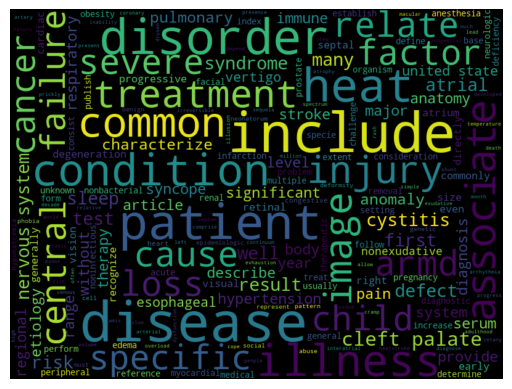

In [9]:
from wordcloud import WordCloud
all_words = " ".join(clean_data)
word_cloud = WordCloud(width=800,height=600,max_font_size=89,random_state=67).generate(all_words)

import matplotlib.pyplot as plt
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()



######  Directly,we cannot apply the machine learning algorithms on the text data

For that ,we convert the text data into the numerical data

then, we can easily apply the machine learning algorithms

For converting the text data into numerical data

we use the vectorization

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

cv = CountVectorizer(stop_words=stopwords.words('english'))
cv = cv.fit(clean_data)
vector = cv.transform(clean_data).toarray()
data_vector = pd.DataFrame(vector)



In [11]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer().fit(vector)
tfidf = tfidf.transform(vector).toarray()
x = normalize(tfidf)



###### Building the machine learning model

In [12]:
from sklearn.cluster import KMeans
true_k=6
model = KMeans(n_clusters=true_k,max_iter=110,n_init=1)
model = model.fit(x)

clust_data = pd.DataFrame(clean_data,columns=['text'])

clust_data['groups'] = model.predict(x)



In [ ]:
creating the elbow method 

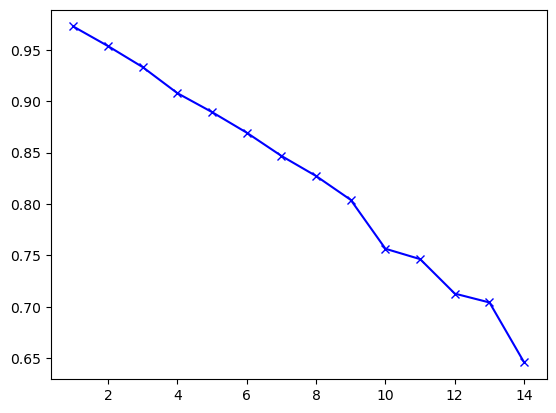

In [13]:
def token(sent):
    tokens = sent.split()
    return tokens
clust_data['words'] = [token(sent) for sent in clust_data['text']]

mapping1={}
mapping2={}
kk = range(1,15)
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
for k in kk:
    model = KMeans(n_clusters=k)
    model = model.fit(x)
    mapping1[k] = sum(np.min(cdist(x,model.cluster_centers_,'euclidean'),axis=1)) / x.shape[0]
    mapping2[k] = model.inertia_

plt.plot(kk,mapping1.values(),'bx-')
    


In [ ]:
def score(file):
    n_grams_tokens = ngrams(nltk.word_tokenize(file),2)
    n_grams = [' '.join(tokens) for tokens in n_grams_tokens]
    
    word_freq={}
    for word in n_grams:
        if word not in word_freq.keys():
            word_freq[word] = 1
        else:
           word_freq[word] += 1
           return word_freq[word]
    for key in word_freq.keys():
        word_freq[word] = word_freq[word] / max(word_freq.values())
    sent_score={}
        
    for sent in nltk.sent_tokenize(file):
        sent_grams = ngrams(word_tokenize(sent), 2)
        sent_grams = [" ".join(grams) for grams in sent_grams]
        for word in sent_grams:
            if word in word_freq.keys():
                if sent not in sent_score.keys():
                    sent_score[sent] = word_freq[word]
                else:
                    sent_score[sent] += word_freq[word]
    mean_value=np.mean(list(sent_score.values())) 
    return mean_value
  

clust_data['n_gram_score'] = [score(file) for file in clean_data]
        